## Experimenting with opencv

In [1]:
import cv2
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

imagePath = "BCCD/JPEGImages"
csvPath = "BCCD/CSVAnnotations"

# red blood cells are red, platelets green, white blood cells are blue
colors = {'RBC': (255,0,0), 'Platelets': (0,255,0), 'WBC': (0,0,255)}

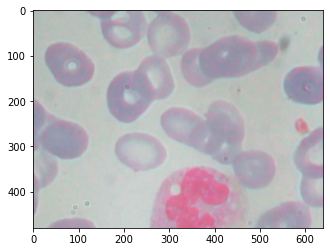

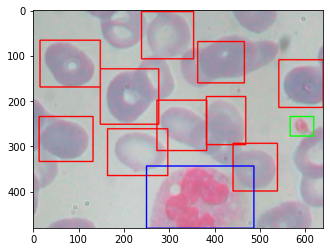

In [6]:
# Show example image and the objects
fileNum = "315"
jpgFile = "BloodImage_00" + fileNum + ".jpg"
csvFile = "BloodImage_00" + fileNum + ".csv"
img = cv2.imread(os.path.join(imagePath, jpgFile))
plt.imshow(img)

objects = pd.read_csv(os.path.join(csvPath, csvFile))
for i, row in objects.iterrows():
    filename, cell_type, xmin, xmax, ymin, ymax = row
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), colors[cell_type], 2)
plt.figure()
plt.imshow(img)

1251


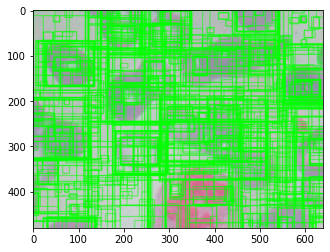

In [7]:
cv2.setUseOptimized(True);
# draw all bounding boxes produced by selective search
img = cv2.imread(os.path.join(imagePath, jpgFile))
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imgOut = img.copy()
print(len(rects))
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
    cv2.rectangle(imgOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
plt.imshow(imgOut)

In [8]:
# Calculate intersection/union ratio
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [9]:
IMG_SIZE = 224

In [92]:
# Create our training set from the proposed regions. For each image take at most MAXCOUNT each
# of positive and negative samples to make an even training set
labels = {'WBC': 3, 'RBC': 2, 'Platelets': 1, 'Background': 0}

def build_training(MAXCOUNT=30):
    train_images=[]
    train_labels=[]

    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    for i, filename in enumerate(os.listdir(imagePath)):
        print(i, filename)
        csvName = filename.split(".")[0]+".csv"
        image = cv2.imread(os.path.join(imagePath, filename))
        objectsDf = pd.read_csv(os.path.join(csvPath, csvName))
        objects = []
        for idx, row in objectsDf.iterrows():
            filename, cell_type, xmin, xmax, ymin, ymax = row
            if xmin < xmax and ymin < ymax:
                objects.append({"x1": xmin, "x2": xmax, "y1": ymin, "y2": ymax, "label": cell_type})

        ss.setBaseImage(image)
        ss.switchToSelectiveSearchFast()
        rects = ss.process()
        imgout = image.copy()

        trueCount = 0
        falseCount = 0
        for (x,y,w,h) in rects[:min(2000, len(rects))]:
            rect = {"x1": x, "x2": x+w, "y1": y, "y2": y+h}
            if trueCount < MAXCOUNT or falseCount < MAXCOUNT:
                for obj in objects:
                    iou = get_iou(obj, rect)
                    if trueCount < MAXCOUNT and iou > 0.7:
                        resized = cv2.resize(imgout[y:y+h,x:x+w], (IMG_SIZE,IMG_SIZE), interpolation = cv2.INTER_AREA)
                        train_images.append(resized)
                        train_labels.append(labels[obj['label']])
                        trueCount += 1

                    if falseCount < MAXCOUNT and iou < 0.3:
                        resized = cv2.resize(imgout[y:y+h,x:x+w], (IMG_SIZE,IMG_SIZE), interpolation = cv2.INTER_AREA)
                        train_images.append(resized)
                        train_labels.append(0)
                        falseCount += 1
            else:
                break
    
    return np.array(train_images), np.array(train_labels)

In [46]:
xTrain, yTrain = build_training()

In [47]:
print("Dataset shape: {}".format(xTrain.shape))
print("Label shape: {}".format(yTrain.shape))

Dataset shape: (17045, 224, 224, 3)
Label shape: (17045,)


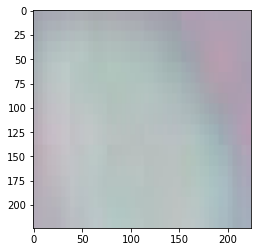

In [13]:
plt.imshow(xTrain[0])

## Training model

Referring to https://github.com/ByeongGil-Jung/Keras-CNN-RGB-Images/blob/master/src/d2_keras.ipynb

In [2]:
import keras

In [48]:
num_classes = 4
labels_one_hot = keras.utils.np_utils.to_categorical(yTrain, num_classes)

xTrain = xTrain.astype("float32")
xTrain /= 255.

In [51]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(xTrain, labels_one_hot, test_size=0.1)

In [52]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

In [53]:
model = Sequential()

model.add(Conv2D(32, (5, 5), padding="same", activation="relu", input_shape=x_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(2), padding="same"))

model.add(Conv2D(32, (5, 5), activation="relu", strides=(2,2), padding="same"))
model.add(MaxPooling2D(pool_size=(2), padding="same"))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(124, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(124, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation="softmax"))

In [55]:
# load previous weights
model.load_weights('weights.h5')

In [71]:
model.save("model", save_format='tf')

INFO:tensorflow:Assets written to: model/assets


In [77]:
epochs = 3

In [74]:
from tensorflow.keras import optimizers

batch_size = 128
lr = 0.001
decay = 1e-6

optimizer = optimizers.RMSprop(learning_rate=lr, decay=decay)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [78]:
history = model.fit(
    x_train, 
    y_train, 
    batch_size=batch_size, 
    epochs=epochs, validation_data=(x_test, y_test), 
    shuffle=True, 
    verbose=1
)

Epoch 1/3
120/120 [==============================] - 328s 3s/step - loss: 0.0988 - accuracy: 0.9694 - val_loss: 0.0760 - val_accuracy: 0.9801
Epoch 2/3
120/120 [==============================] - 339s 3s/step - loss: 0.0954 - accuracy: 0.9716 - val_loss: 0.0524 - val_accuracy: 0.9871
Epoch 3/3
120/120 [==============================] - 321s 3s/step - loss: 0.0901 - accuracy: 0.9710 - val_loss: 0.1257 - val_accuracy: 0.9677


## Predicting

In [33]:
labelColors = {1: (0,255,0), 2: (255,0,0), 3: (0,0,255)}

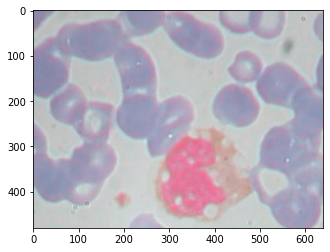

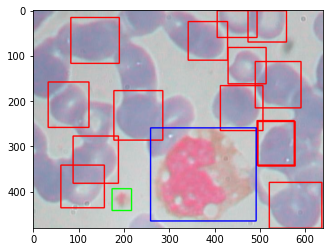

In [90]:
# Show example image and the objects
fileNum = "104"
jpgFile = "BloodImage_00" + fileNum + ".jpg"
csvFile = "BloodImage_00" + fileNum + ".csv"
img = cv2.imread(os.path.join(imagePath, jpgFile))
plt.imshow(img)

objects = pd.read_csv(os.path.join(csvPath, csvFile))
for i, row in objects.iterrows():
    filename, cell_type, xmin, xmax, ymin, ymax = row
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), colors[cell_type], 2)
plt.figure()
plt.imshow(img)

1473
14


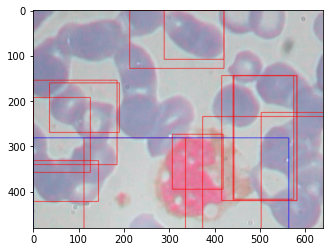

In [91]:
import time
img = cv2.imread(os.path.join(imagePath, jpgFile))

ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imgOut = img.copy()
print(len(rects))
count = 0
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
#     a = time.time()
    resized = cv2.resize(imgout[y:y+h,x:x+w], (IMG_SIZE,IMG_SIZE), interpolation = cv2.INTER_AREA).astype('float32')
    resized /= 255. 
    resized = np.expand_dims(resized, axis=0)
#     b = time.time()
    pred = model.predict(resized)
    label = (np.argmax(pred, axis=1)[0])
#     c = time.time()
#     print(f'Total time: {1000*(c-a):2f}ms. Pred time: {1000*(c-b):2f}')
    if label > 0 and pred[0][label] >= 0.99:
        count += 1
        cv2.rectangle(imgOut, (x, y), (x+w, y+h), labelColors[label], 1, cv2.LINE_AA)
plt.imshow(imgOut)
print(count)